# Fake News Project - Data Analysis

In [2]:
# imports
import pandas as pd
import re
import os
import multiprocess as mp
import matplotlib.pyplot as plt
from collections import Counter

# Initialization

chunk_size = 50000  # Process 50,000 rows at a time
num_cores = os.cpu_count()  # Use all available CPU cores



Task 2

In [3]:
# Path to the CSV file on your VM
file_path = "995,000_rows.csv"

# Load the CSV into a DataFrame, treating all columns as strings
df = pd.read_csv(file_path, dtype=str)

# Display basic structure
df.info()

# Peek at the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995000 entries, 0 to 994999
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        994999 non-null  object
 1   id                994993 non-null  object
 2   domain            994989 non-null  object
 3   type              947214 non-null  object
 4   url               994989 non-null  object
 5   content           994988 non-null  object
 6   scraped_at        994987 non-null  object
 7   inserted_at       994987 non-null  object
 8   updated_at        994987 non-null  object
 9   title             986394 non-null  object
 10  authors           552243 non-null  object
 11  keywords          0 non-null       object
 12  meta_keywords     956210 non-null  object
 13  meta_description  469894 non-null  object
 14  tags              230919 non-null  object
 15  summary           0 non-null       object
 16  source            214922 non-null  obj

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,732,7444726.0,nationalreview.com,political,http://www.nationalreview.com/node/152734/%E2%...,Plus one article on Google Plus\n\n(Thanks to ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Iran News Round Up,NaN,NaN,"['National Review', 'National Review Online', ...",NaN,NaN,NaN,NaN
1,1348,6213642.0,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2012/06/the-c...,The Cost Of The Best Senate Banking Committee ...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,The Cost Of The Best Senate Banking Committee ...,NaN,NaN,[''],NaN,NaN,NaN,NaN
2,7119,3867639.0,dailycurrant.com,satire,http://dailycurrant.com/2016/01/18/man-awoken-...,Man Awoken From 27-Year Coma Commits Suicide A...,2017-11-27T01:14:21.395055,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Man Awoken From 27-Year Coma Commits Suicide A...,NaN,NaN,[''],NaN,NaN,NaN,NaN
3,1518,9560791.0,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,WHEN Julia Geist was asked to draw a picture o...,2018-02-11 00:46:42.632962,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Opening a Gateway for Girls to Enter the Compu...,NaN,NaN,"['Computers and the Internet', 'Women and Girl...",WHEN Julia Geist was asked to draw a picture o...,NaN,NaN,nytimes
4,9345,2059625.0,infiniteunknown.net,conspiracy,http://www.infiniteunknown.net/2011/09/14/100-...,– 100 Compiled Studies on Vaccine Dangers (Act...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,100 Compiled Studies on Vaccine Dangers – Infi...,NaN,NaN,[''],NaN,"Lymphoma, Hepatitis B, Immune System, Health, ...",NaN,NaN


In [4]:
# Count missing values per column
missing_counts = df.isna().sum().sort_values(ascending=False)

# Show % missing
missing_percentage = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percentage.map('{:.2f}%'.format)
})

missing_summary

,Missing Count,Missing %
summary,995000,100.00%
keywords,995000,100.00%
source,780078,78.40%
tags,764081,76.79%
meta_description,525106,52.77%
authors,442757,44.50%
type,47786,4.80%
meta_keywords,38790,3.90%
title,8606,0.86%
updated_at,13,0.00%


In [5]:
url_total, date_total, num_total = 0, 0, 0
freq_raw = Counter()

def analyze_raw(text):
    if pd.isna(text): return 0, 0, 0, []
    text = str(text).lower()
    url_count = len(re.findall(r'https?://\S+', text))
    date_count = len(re.findall(r'\b\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\b', text))
    num_count = len(re.findall(r'\b\d+\b', text))
    tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text)
    return url_count, date_count, num_count, tokens

print("Analyzing 995,000_rows.csv...")
reader_raw = pd.read_csv("995,000_rows.csv", chunksize=chunk_size)
for i, chunk in enumerate(reader_raw):
    print(f"Chunk {i+1}")
    chunk = chunk.dropna(subset=["content"])
    with mp.Pool(num_cores) as pool:
        results = pool.map(analyze_raw, chunk["content"])

    for url_c, date_c, num_c, toks in results:
        url_total += url_c
        date_total += date_c
        num_total += num_c
        freq_raw.update(toks)

print(f"\n Raw content analysis complete.")
print(f"Total URLs: {url_total}")
print(f"Total Dates: {date_total}")
print(f"Total Numbers: {num_total}")
print(f"Top 100 Raw Words:\n{freq_raw.most_common(100)}")


Analyzing 995,000_rows.csv...
Chunk 1


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 2
Chunk 3


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):
/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 9
Chunk 10
Chunk 11
Chunk 12


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):
/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 13
Chunk 14


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 15
Chunk 16


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 17
Chunk 18
Chunk 19


/var/folders/jy/c7h9f73j73v5pv4bpl0m77zh0000gp/T/ipykernel_1755/3860917580.py:15: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader_raw):


Chunk 20

 Raw content analysis complete.
Total URLs: 215664
Total Dates: 88439
Total Numbers: 9720106
Top 100 Raw Words:
[('the', 26232180), ('to', 12666754), ('of', 12497222), ('and', 11517256), ('in', 8725582), ('that', 5673578), ('is', 5076107), ('for', 4389281), ('it', 3631895), ('on', 3522955), ('with', 2834864), ('as', 2805334), ('was', 2447131), ('are', 2445002), ('by', 2345185), ('this', 2287673), ('you', 2244528), ('at', 2199248), ('be', 2177365), ('he', 2172296), ('not', 2115427), ('have', 2099744), ('from', 2043596), ('they', 1733605), ('an', 1724400), ('has', 1709921), ('we', 1700261), ('but', 1653998), ('his', 1632684), ('or', 1535511), ('said', 1415649), ('who', 1356448), ('will', 1334669), ('their', 1270086), ('all', 1194507), ('more', 1161514), ('one', 1120010), ('about', 1109372), ('new', 1065513), ('which', 1027538), ('can', 1005940), ('if', 1002864), ('up', 979407), ('would', 965523), ('what', 954040), ('there', 926889), ('been', 925277), ('had', 915948), ('were', 9


 Analyzing 995pre.csv...
 Chunk 1
 Chunk 2
 Chunk 3
 Chunk 4
 Chunk 5
 Chunk 6
 Chunk 7
 Chunk 8
 Chunk 9
 Chunk 10
 Chunk 11
 Chunk 12
 Chunk 13
 Chunk 14
 Chunk 15
 Chunk 16
 Chunk 17
 Chunk 18
 Chunk 19

Cleaned token analysis complete.
Top 100 Cleaned Words:
[('num', 8481631), ('said', 1306449), ('one', 1000802), ('new', 941506), ('time', 875164), ('would', 874508), ('year', 825193), ('state', 817454), ('peopl', 783280), ('like', 744235), ('use', 631771), ('also', 623498), ('make', 553346), ('us', 549024), ('say', 536840), ('go', 526826), ('get', 515474), ('even', 513831), ('work', 470427), ('govern', 455456), ('first', 454460), ('could', 452717), ('report', 449511), ('presid', 449160), ('two', 448558), ('american', 446520), ('news', 446163), ('day', 444303), ('come', 442346), ('nation', 438103), ('right', 437623), ('mani', 437110), ('trump', 434085), ('stori', 430469), ('continu', 419553), ('read', 411852), ('take', 403123), ('world', 397523), ('may', 397134), ('last', 395430), (

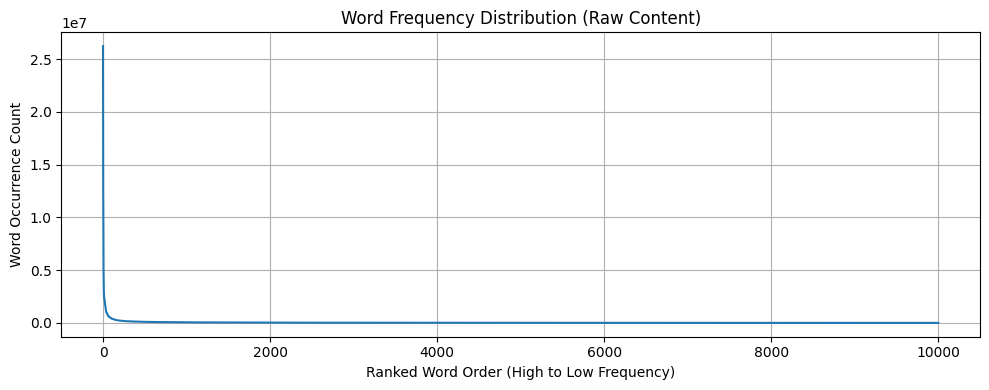

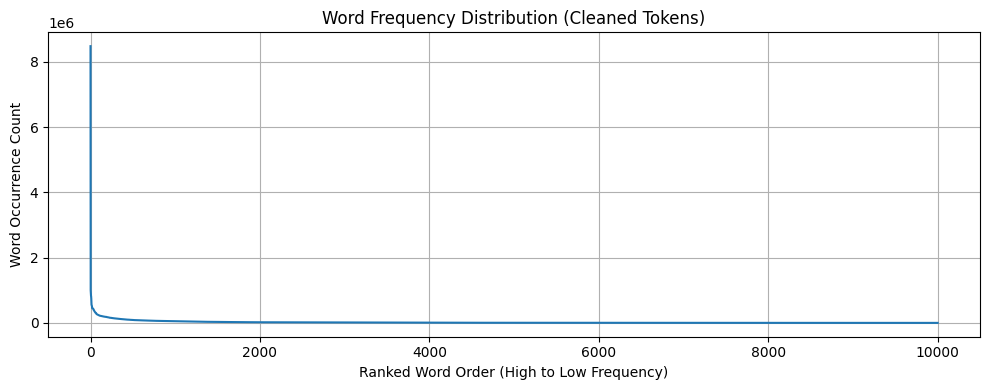

In [6]:
import ast

# Parameters

freq_clean = Counter()

def parse_tokens(token_str):
    try:
        # Safely evaluate token string into a Python list
        tokens = ast.literal_eval(token_str)
        # Only accept lists of strings
        if isinstance(tokens, list) and all(isinstance(t, str) for t in tokens):
            return tokens
    except:
        pass
    return []

print("\n Analyzing 995pre.csv...")
reader_clean = pd.read_csv("995pre.csv", chunksize=chunk_size)

for i, chunk in enumerate(reader_clean):
    print(f" Chunk {i+1}")
    chunk = chunk.dropna(subset=["tokens"])
    token_lists = chunk["tokens"].map(parse_tokens)
    for tokens in token_lists:
        freq_clean.update(tokens)

# Output top tokens
print(f"\nCleaned token analysis complete.")
print(f"Top 100 Cleaned Words:\n{freq_clean.most_common(100)}")

# Plot frequency distribution
def plot_freq(counter, title):
    top_words = counter.most_common(10000)
    plt.figure(figsize=(10, 4))
    plt.plot([freq for _, freq in top_words])
    plt.title(title)
    plt.xlabel("Ranked Word Order (High to Low Frequency)")
    plt.ylabel("Word Occurrence Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_freq(freq_raw, "Word Frequency Distribution (Raw Content)")
plot_freq(freq_clean, "Word Frequency Distribution (Cleaned Tokens)")

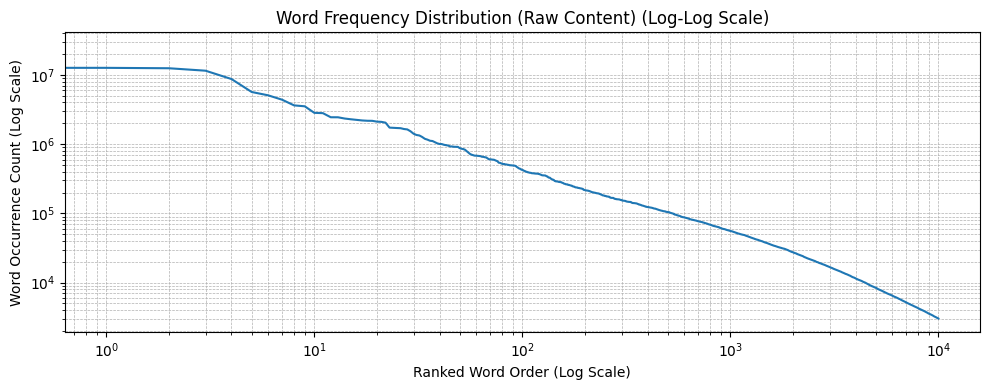

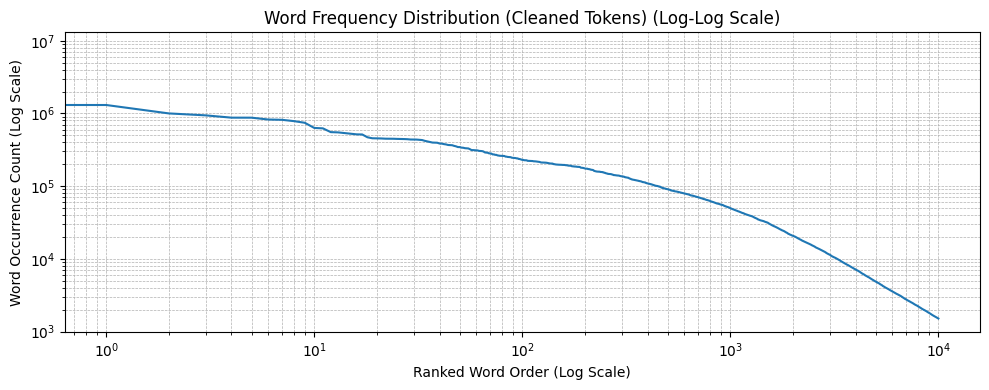

In [7]:
# Plot frequency distribution on log-log scale
def plot_freq_loglog(counter, title):
    top_words = counter.most_common(10000)
    freqs = [freq for _, freq in top_words]
    
    plt.figure(figsize=(10, 4))
    plt.loglog(freqs)
    plt.title(f"{title} (Log-Log Scale)")
    plt.xlabel("Ranked Word Order (Log Scale)")
    plt.ylabel("Word Occurrence Count (Log Scale)")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
plot_freq_loglog(freq_raw, "Word Frequency Distribution (Raw Content)")
plot_freq_loglog(freq_clean, "Word Frequency Distribution (Cleaned Tokens)")
